In [23]:
#!pip install  meteva
import os,sys
import datetime as dt
import xarray as xr
import time
from datetime import datetime
import numpy as np
# np.set_printoptions(threshold=np.inf)
import seaborn as sns
import pandas as pd
import glob as glob
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import meteva.base as meb      # 该模块用于IO和基础计算
import meteva.method as mem    # 该模块基础了检验的基础算法
import meteva.product as mpd   # 该模块包含了检验的工具      
import copy
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
import torch

## Descriptive analysis of the forecasts and ground truth data

In [3]:
#save_dir = '/p/scratch/deepacf/deeprain/ji4/Downsacling/results/swinUnet_exp1019_origin_booster_3years/prediction_18000'
#save_dir = "/p/home/jusers/gong1/juwels/bing_folder/downscaling_maelstrom/results/exp_20230319_swinunet_remove_last_batch_test"
#save_dir = "/p/scratch/deepacf/deeprain/ji4/Downsacling/results/unet_exp_20230130_580000_G"
save_dir = "/p/home/jusers/gong1/hdfml/bing/downscaling_maelstrom/results/exp_20230421_epoch20_postprocess/"
model_name = 'unet'
#prcp_downs_swinUnet_1.nc
filename = 'prcp_downs_'+model_name+'_1.nc'
filepath = os.path.join(save_dir,filename)
with xr.open_dataset(filepath, engine="netcdf4") as df:
    print(df)
    fcst = np.array(df['fcst'][:])
    refe = np.array(df['refe'][:])
    inpt = np.array(df['inputs'][:])
    time = np.array(df['time'][:]) 
    

<xarray.Dataset>
Dimensions:    (pitch_idx: 100032, time: 9399, lat: 160, lon: 160, lat_in: 16,
                lon_in: 16)
Coordinates:
  * pitch_idx  (pitch_idx) int32 93461 26074 45994 39126 ... 5457 67125 74260
  * time       (time) datetime64[ns] 2020-01-01T07:00:00 ... 2020-01-19T05:00:00
Dimensions without coordinates: lat, lon, lat_in, lon_in
Data variables:
    fcst       (time, lat, lon) float32 ...
    refe       (time, lat, lon) float32 ...
    inputs     (time, lat_in, lon_in) float32 ...
Attributes:
    description:  Precipitation downscaling data.


In [4]:
np.min(fcst)

3.7858263e-06

In [5]:
np.min(refe)

-9.313226e-10

In [6]:
np.max(fcst)

1685.6677

In [7]:
np.max(refe)

13.862568

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


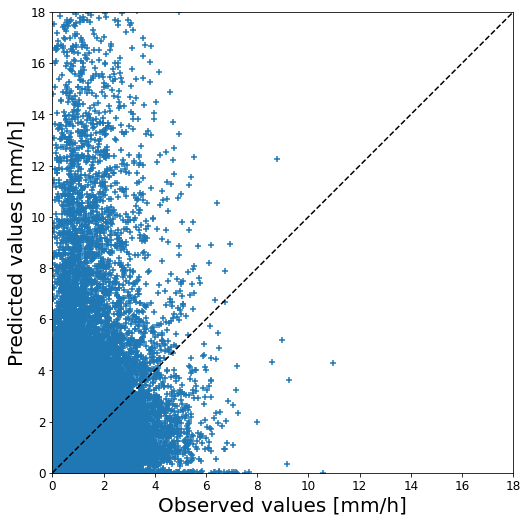

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
plt.scatter(refe[:,::10,::10].flatten(),fcst[:,::10,::10].flatten(),marker='+')

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.title('threshold: '+threshold+'mm', fontsize=14,loc='center',pad=6)
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.58, 0.75), fontsize=14) # 'upper right', bbox_to_anchor=(1.38, 0.8),

ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

ax.set_xlim([0, 18])
ax.set_ylim([0, 18])
ax.set_xlabel("Observed values [mm/h]",fontsize=20)
ax.set_ylabel("Predicted values [mm/h]",fontsize=20)

figname = model_name+'_scatters'
figpath = os.path.join(save_dir,figname)
#plt.savefig(figpath, bbox_inches="tight")
plt.show()

## Calculate the evaluation metrics

In [11]:
#https://www.showdoc.com.cn/meteva/3975610088390562
#pc(ob, fo,grade_list=[1e-30],compare = “>=”):准确率 基于原始数据计算accuracy： （Hits+ Correct negatives）/Total，反映被正确预报的样本占比
#pod(ob, fo,grade_list=[1e-30],compare = “>=”)命中率(并行）又称基于原始数据计算hit rate： Hits/(Hits + Misses)，反映观测的正样本中多少被预报
#pc_of_sun_rain 晴雨准确率#基于原始数据计算accuracy： （Hits+ Correct negatives）/Total，反映被正确预报的样本占比
#pofd 报空率: 基于原始数据计算Probability of false detection： False alarms/(False alarms + Correct negatives)，反映观测负样本被预报为正样本的比例
#far 空报率:far(ob, fo,grade_list=[1e-30],compare = “>=”)基于原始数据计算False alarm ratio： False alarms/(Hit + False alarms)，反映预报的正样本中实际未发生的比例
#mr: 漏报率: mr(ob, fo,grade_list=[1e-30],compare = “>=”) 基于原始数据计算Miss ratio： Misses/(Hit + Misses)，反映观测正样本被预报为负样本的比例
#ets: ets(ob, fo,grade_list=[1e-30],compare = “>=”) 基于原始数据计算ets： (Hit-Hit_random) /(Hit + Misses+ False alarms - Hit_random)，反映预测的正样本与观察到的正样本对应的程度如何, 其中扣除了随机预报产生的命中数量，Hit_random = Forecast yes × Observed yes / Total
#fscore: fscore(ob, fo,grade_list=[1e-30],compare = “>=”,belta=1) 基于原始数据计算fscore=(1+belta^2) (pod sr)/(belta^2 sr + pod) = (1+belta^2) hit/((1+belta^2) hit + belta^2 Mis + False alarms)
#TS评分ts(ob, fo,grade_list=[1e-30],compare = “>=”) 基于原始数据计算ts： Hit /(Hit + Misses+ False alarms)，反映预测的正样本与观察到的正样本对应的程度如何
grade_list = [0.1,5,10,20]
half_window_size_list = [3,5,10]
rmse = []
corr = []
pc = []
pc_of_sun_rain = []
pod = []
pofd = []
far = []
mr = []
bias = []
ts = []
ets = []
fscore = []
fss_middle = []
for i in range(refe.shape[0]):
    rmse.append(mem.rmse(refe[i],fcst[i]))
    corr.append(mem.corr(refe[i],fcst[i]))    
    pc.append(mem.pc(refe[i],fcst[i],grade_list=grade_list))
    pc_of_sun_rain.append(mem.pc_of_sun_rain(refe[i],fcst[i]))
    pod.append(mem.pod(refe[i],fcst[i],grade_list=grade_list))
    pofd.append(mem.pofd(refe[i],fcst[i],grade_list=grade_list))
    far.append(mem.far(refe[i],fcst[i],grade_list=grade_list))
    mr.append(mem.mr(refe[i],fcst[i],grade_list=grade_list))
    bias.append(mem.bias(refe[i],fcst[i],grade_list=grade_list))
    ts.append(mem.ts(refe[i],fcst[i],grade_list=grade_list))
    ets.append(mem.ets(refe[i],fcst[i],grade_list=grade_list))
    fscore.append(mem.fscore(refe[i],fcst[i],grade_list=grade_list))
    fss_middle.append(mem.fbs_pobfo(refe[i],fcst[i],grade_list=grade_list, 
                                    half_window_size_list=half_window_size_list))

rmse = np.stack(rmse)    
corr = np.stack(corr)    
pc = np.stack(pc)
pc_of_sun_rain = np.stack(pc_of_sun_rain)
pod = np.stack(pod)
pofd = np.stack(pofd)
far = np.stack(far)
mr = np.stack(mr)
bias = np.stack(bias)
ts = np.stack(ts)
ets = np.stack(ets)
fscore = np.stack(fscore)
fss_middle_all = np.stack(fss_middle)

fss = np.ones([refe.shape[0],len(grade_list),len(half_window_size_list)])
for k in range(refe.shape[0]):
    for i in range(len(grade_list)):
        for j in range(len(half_window_size_list)):
            fss[k,i,j] = 1 - fss_middle_all[k,j,i,2].sum()/(fss_middle_all[k,j,i,0].sum()+fss_middle_all[k,j,i,1].sum())

corr[np.where(corr>1)] = np.nan
pc[np.where(pc>1)] = np.nan
pc_of_sun_rain[np.where(pc_of_sun_rain>1)] = np.nan
pod[np.where(pod>1)] = np.nan
pofd[np.where(pofd>1)] = np.nan
far[np.where(far>1)] = np.nan
mr[np.where(mr>1)] = np.nan
ts[np.where(ts>1)] = np.nan #if the devided by zero, then the ts is not able to calcualted and we force to nan value
ets[np.where(ets>1)] = np.nan
fss[np.where(fss>1)] = np.nan
            

In [18]:
data = {'RMSE':  rmse,
        'CORR':  corr,
        # 'PC_of_sun_rain': pc_of_sun_rain,
        'CSI0.1': ts[:,0],
        'CSI5': ts[:,1],
#         'TS10': ts[:,3],
#         'ETS0.1': ets[:,0],
#         'ETS5': ets[:,1],
# #         'ETS10': ets[:,3],
#         'FAR0.1': far[:,0],
#         'FAR5': far[:,1],
# #         'FAR10': far[:,3],
#         'POM0.1': mr[:,0],
#         'POM5': mr[:,1],
# #         'POM10': mr[:,3],
        'FSS0.1': fss[:,0,1],
        'FSS5': fss[:,1,1],
#         'FSS10': fss[:,3,1],
       }
unet_all_vars = pd.DataFrame(data=data)

In [17]:
unet_all_vars

,RMSE,CORR,PC_of_sun_rain,CSI0.1,CSI5,FSS0.1,FSS5
0,0.000004,0.000000,1.000000,NaN,NaN,NaN,NaN
1,0.000004,0.000000,1.000000,NaN,NaN,NaN,NaN
2,0.051855,0.853341,0.997500,0.583333,NaN,0.875137,NaN
3,0.004919,0.697567,0.998750,0.000000,NaN,0.000000,NaN
4,0.011596,0.831539,0.996680,0.408377,NaN,0.926352,NaN
...,...,...,...,...,...,...,...
9394,0.000004,0.000000,1.000000,NaN,NaN,NaN,NaN
9395,0.000559,0.000000,1.000000,NaN,NaN,NaN,NaN
9396,0.123826,0.789599,0.968672,0.605822,NaN,0.910198,NaN
9397,0.003658,0.605721,0.999805,0.000000,NaN,0.000000,NaN


In [19]:
unet_all_vars.mean()

RMSE      0.183157
CORR      0.318150
CSI0.1    0.407946
CSI5      0.011241
FSS0.1    0.610427
FSS5      0.034107
dtype: float64

Besides the evlation metrics above, we also folllow the study from [Leinonen 2020](https://arxiv.org/abs/2005.10374) to use the MS-SSIM and log spectral distance (LSD) metrics

In [9]:
torch_fcst = torch.tensor(fcst).view(fcst.shape[0],-1,fcst.shape[1],fcst.shape[2])
torch_refe = torch.tensor(refe).view(fcst.shape[0],-1,fcst.shape[1],fcst.shape[2])
ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=6,kernel_size=7)

In [21]:
ms_ssim(torch_fcst, torch_refe)

tensor(nan)

tensor(nan)

tensor(nan)

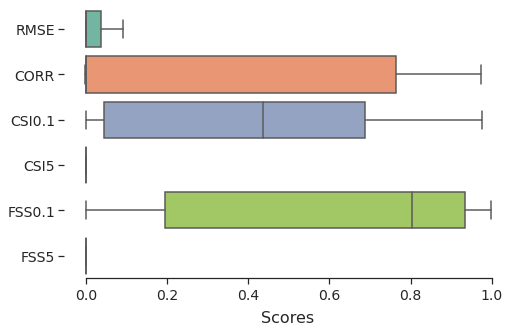

In [21]:
fig_path = os.path.join(save_dir,'unet_scores')
f, ax = plt.subplots(figsize=(8, 5))

sns.set_theme(style="ticks")
ax = sns.boxplot(data=unet_all_vars, orient="h",
                 palette="Set2", showfliers=False)
# ax.axhline(y=0, color="grey", linewidth=.5)
ax.set_xlabel('Scores', fontsize=16, labelpad=8)
# ax.set_ylabel('Continuous Ranked Probability Score', fontsize=14, labelpad=6)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(trim=True, left=True)
# plt.legend(title = "Model", 
#            fontsize = '10', title_fontsize = "10",
#            loc = 2, bbox_to_anchor = (1.01,0.7))
plt.savefig(fig_path, bbox_inches="tight")
plt.show()
plt.close()

## Plot the ground truth and prediction

In [30]:
# create colormaps
clevs = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750])*1e-2
label = 'Precipitation Rate [mm/hour]'
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),`
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
cmap.set_bad(color='grey')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

In [31]:
def spatial_plot(prcp,title,figname):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    if '_in' in title:
        dx, dy = 1, 1
    else:
        dx, dy = 0.1, 0.1
    y, x = np.mgrid[slice(-8, 8+dy, dy),
                slice(-8, 8+dx, dx)]

    cs = plt.pcolormesh(x,y,prcp,cmap=cmap,norm=norm,vmin=0.)
    plt.yticks(np.arange(-8,10,2),fontsize=18)
    plt.xticks(np.arange(-8,10,2),fontsize=18)

    # # add colorbar.
    label = 'Precipitation rate [mm/h]'    
    cbar = plt.colorbar(cs,location='right',pad=0.03)
    cbar.set_label(label,fontsize=20) # 10$\mathregular{^-}$$\mathregular{^1}$ 
    
    plt.title(title, fontsize=20,loc='center',pad=6)

    # save to disk
    #plt.savefig(figname, bbox_inches="tight")
    plt.show()

In [32]:
iet = np.where(np.nansum(refe,(1,2))==np.nanmax(np.nansum(refe,(1,2))))[0][0]

/tmp/ipykernel_31295/3547275331.py:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cs = plt.pcolormesh(x,y,prcp,cmap=cmap,norm=norm,vmin=0.)


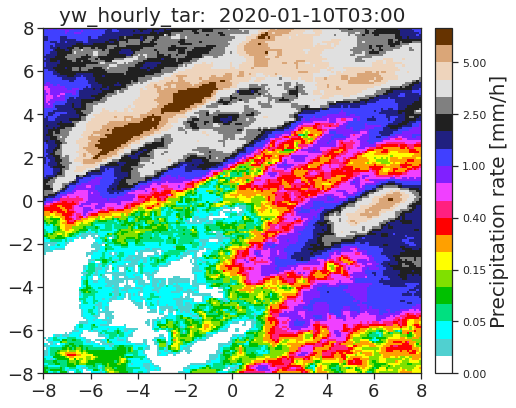

In [33]:
prcp = refe[iet]
tim = str(time[iet])[:16]
title = "yw_hourly_tar:  "+tim
figname = "yw_hourly_tar_"+tim
figpath = os.path.join(save_dir,figname)
spatial_plot(prcp,title,figpath)


/tmp/ipykernel_31295/3547275331.py:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cs = plt.pcolormesh(x,y,prcp,cmap=cmap,norm=norm,vmin=0.)


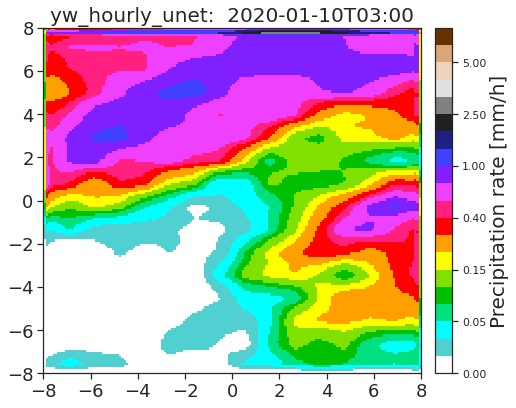

In [34]:
prcp = fcst[iet]
title = "yw_hourly_"+model_name+":  "+tim
figname = "yw_hourly_"+model_name+"_"+tim
figpath = os.path.join(save_dir,figname)
spatial_plot(prcp,title,figpath)

/tmp/ipykernel_31295/3547275331.py:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cs = plt.pcolormesh(x,y,prcp,cmap=cmap,norm=norm,vmin=0.)


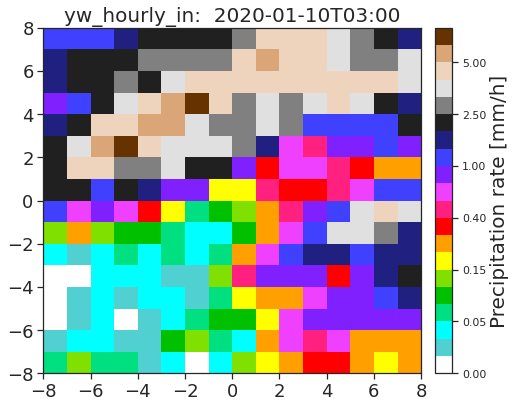

In [35]:
prcp = inpt[iet]
title = "yw_hourly_in:  "+tim
figname = "yw_hourly_in_"+tim
figpath = os.path.join(save_dir,figname)
spatial_plot(prcp,title,figpath)


In [48]:
    # Set default hyper-parameters for all the models and used for wandb log
    config = {"epochs":2
              }
    # This is the model hparameters should be tailored to each model afterwards
    hparams = {}

In [49]:
config.update(hparams)

In [50]:
config

{'epochs': 2}